Marijn van Vliet
# Using domain knowledge in machine learning models
a deep dive into linear regression

# Loading the data

In [1]:
import mne
epochs = mne.read_epochs('subject04-epo.fif')
epochs.metadata

,cue,association,label,FAS,button,reaction-time
71,aandoening,ziekte,6,0.288136,1,1.434433
72,reiken,door,7,0.000000,2,1.500004
73,kil,koud,6,0.287625,1,1.297362
74,winden,vijand,7,0.000000,2,1.356885
75,ikke,kar,7,0.000000,2,1.303920
...,...,...,...,...,...,...
466,roker,god,7,0.000000,2,1.404144
467,kameraad,vriend,6,0.265306,1,1.327876
468,opinie,mening,6,0.292419,1,1.267549
469,bouwen,huis,6,0.280405,1,1.278451


# Epochs: snippets of EEG data

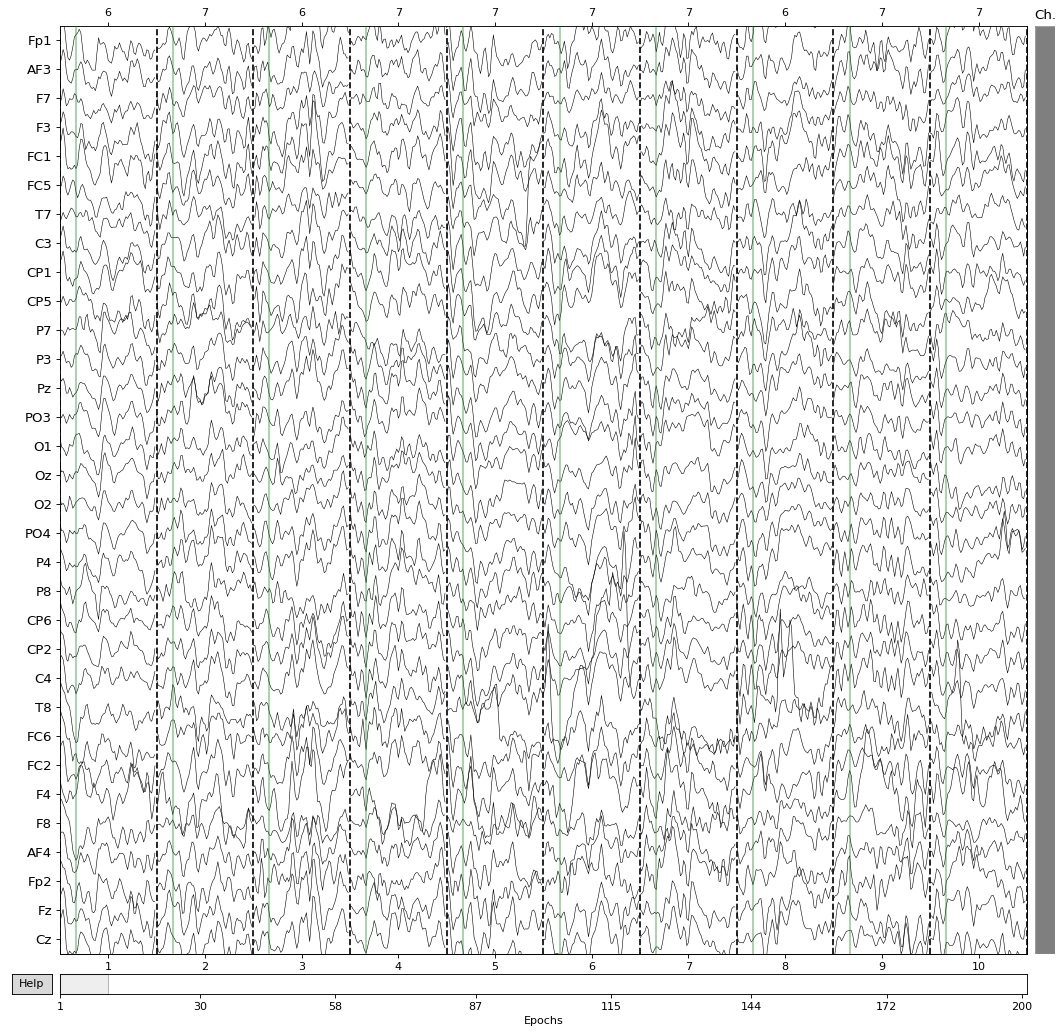

In [2]:
epochs.plot(n_channels=32, n_epochs=10)

# Evoked: averaging across epochs

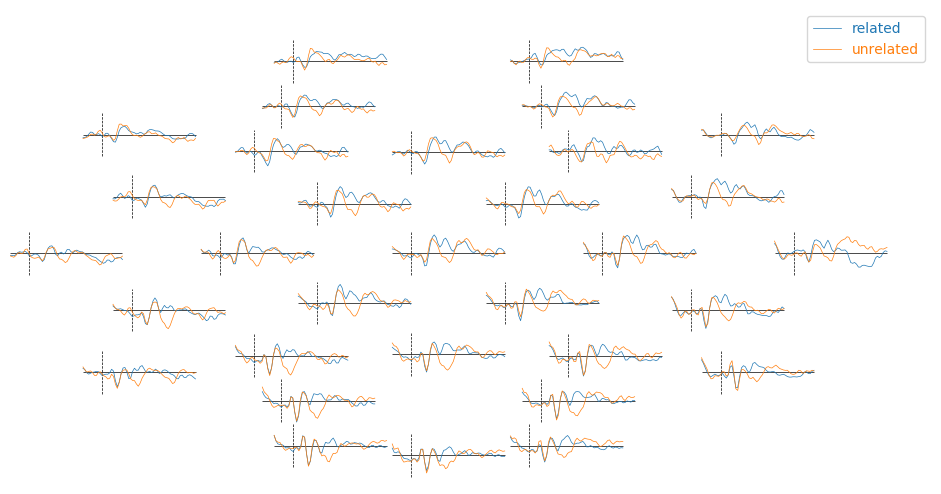

In [3]:
unrelated = epochs['FAS < 0.1'].average()
related = epochs['FAS > 0.1'].average()
mne.viz.plot_evoked_topo([related, unrelated])

# Challenge:
## Deduce the memory priming effect for a word-pair, given the EEG epoch

# Naive approach: average signal in ROI

In [4]:
ROI = epochs.copy()
ROI.pick_channels(['P3', 'Pz', 'P4'])
ROI.crop(0.3, 0.47)

FAS_pred = ROI.get_data().mean(axis=(1, 2))

In [5]:
from scipy.stats import pearsonr
print('Performance: %.2f' % pearsonr(epochs.metadata['FAS'], FAS_pred)[0])

Performance: 0.30


# Machine learning approach: linear regression

In [ ]:
print(epochs.get_data().shape)

In [ ]:
X = epochs.get_data().reshape(200, 32 * 60)
y = epochs.metadata['FAS'].values

from sklearn.preprocessing import normalize
X = normalize(X)

print('X:', X.shape)
print('y:', y.shape)

# Performing linear regression

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X, y)

FAS_pred = model.predict(X)
print('Performance: %.2f (to beat: 0.30)' % pearsonr(epochs.metadata['FAS'], FAS_pred)[0])

In [ ]:
from sklearn.model_selection import cross_val_predict

FAS_pred = cross_val_predict(model, X, y, cv=10)
print('Performance: %.2f (to beat: 0.30)' % pearsonr(epochs.metadata['FAS'], FAS_pred)[0])

# Inspecting the weights

In [ ]:
model.fit(X, y)
weights = model.coef_.reshape(32, 60)

In [ ]:
ev = mne.EvokedArray(weights, epochs.info, tmin=epochs.times[0], comment='weights')
ev.plot_topo()

What's going on here?
https://users.aalto.fi/~vanvlm1/posthoc/regression.html

# The post-hoc framework

 1. Data covariance matrix
 2. Haufe pattern matrix
 3. Normalizer

In [ ]:
from posthoc import Workbench

model = Workbench(LinearRegression())
model.fit(X, y)

cov_X = X.T @ X
pattern = model.pattern_
normalizer = model.normalizer_

# The data covariance

In [ ]:
from matplotlib import pyplot as plt

plt.matshow(cov_X, cmap='magma')

# Show channel names
plt.xticks(range(0, 32 * 60, 60), epochs.ch_names, rotation=90)
plt.yticks(range(0, 32 * 60, 60), epochs.ch_names)

plt.gcf()

# Shrinking the covariance

In [ ]:
# Amount of shrinkage
alpha = 0.75

# Shrinkage formula
shrinkage_target = np.identity(32 * 60) * np.trace(cov_X) / len(cov_X)
cov_X_mod = alpha * shrinkage_target + (1 - alpha) * cov_X

# Plot shrunk covariance
plt.matshow(cov_X_mod, cmap='magma')
plt.xticks(range(0, 32 * 60, 60), epochs.ch_names, rotation=90)
plt.yticks(range(0, 32 * 60, 60), epochs.ch_names)
plt.gcf()

# Post-hoc modification of the model

In [ ]:
from posthoc.cov_estimators import ShrinkageKernel

model = Workbench(LinearRegression(), cov=ShrinkageKernel(alpha=0.97))

FAS_pred = cross_val_predict(model, X, y, cv=10)
print('Performance: %.2f (to beat: 0.30)' % pearsonr(epochs.metadata['FAS'], FAS_pred)[0])

# The pattern matrix

In [ ]:
pattern = mne.EvokedArray(pattern.reshape(32, 60), epochs.info, epochs.times[0], comment='pattern')
pattern.plot_topo()

# Modifying the pattern matrix

In [ ]:
import numpy as np

def pattern_modifier(pattern, X_train=None, y_train=None, mu=0.36, sigma=0.06):
    pattern = pattern.reshape(32, 60)
    
    #mu = 0.4
    #sigma = 0.1
    
    # Define mu and sigma in samples
    mu = np.searchsorted(epochs.times, mu)
    sigma = sigma  * epochs.info['sfreq']
    
    # Formula for Gaussian curve
    kernel = np.exp(-0.5 * ((np.arange(60) - mu) / sigma) ** 2)
    
    return (pattern * kernel).ravel()

In [ ]:
pattern_mod = pattern_modifier(pattern)
pattern_mod = mne.EvokedArray(pattern_mod.reshape(32, 60), epochs.info, epochs.times[0], comment='pattern')
pattern_mod.plot_topo()

# Post-hoc modifying the pattern

In [ ]:
model = Workbench(LinearRegression(), cov=ShrinkageKernel(0.97), pattern_modifier=pattern_modifier)
FAS_pred = cross_val_predict(model, X, y, cv=10)

print('Performance: %.2f (to beat: 0.30, 0.35)' % pearsonr(epochs.metadata['FAS'], FAS_pred)[0])

To find out more, read the paper!

https://www.biorxiv.org/content/10.1101/518662v2

Marijn van Vliet & Riitta Salmelin  
**Post-hoc modification of linear models: combining machine learning with domain information to make solid inferences from noisy data**  
NeuroImage (in press.)

# The normalizer

In [ ]:
print(normalizer)

# Automatic optimization

In [ ]:
from posthoc import WorkbenchOptimizer
model = WorkbenchOptimizer(LinearRegression(), cov=ShrinkageKernel(0.95),
                           pattern_modifier=pattern_modifier, pattern_param_x0=[0.4, 0.05], pattern_param_bounds=[(0, 0.8), (0.01, 0.5)],
                           scoring=scorer)
model.fit(X, y)